<a href="https://colab.research.google.com/github/Lera06/FlowersVision/blob/main/FlowersVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: FlowersMini_DenseNet161

## 0. Getting Setup

In [1]:
# Import libraries
import os
import random
import glob
import json

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torch import nn
from torch.utils.data import DataLoader

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

import pathlib
import shutil
import skimage.io as skio
import scipy.io as scp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## 1. Setup device-agnostic code

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## 2. Downloading the Data and Visualizing it

### 2.1 Downloading the whole Flower-102 dataset

In [ ]:
# Setup data directory
import pathlib
data_dir = pathlib.Path("../data")

In [ ]:
# Download the Flowers-102 dataset from torchvision.datasets
train_dataset = datasets.Flowers102(root=data_dir,
                                 split='train',
                                 download=True)
validation_dataset = datasets.Flowers102(root=data_dir,
                                      split='val',
                                      download=True)
test_dataset = datasets.Flowers102(root=data_dir,
                                split='test',
                                download=True)

100%|██████████| 345M/345M [00:15<00:00, 22.9MB/s]


Extracting ../data/flowers-102/102flowers.tgz to ../data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 461kB/s]


100%|██████████| 15.0k/15.0k [00:00<00:00, 12.0MB/s]


In [ ]:
# Check the datasets
train_dataset, validation_dataset, test_dataset

(Dataset Flowers102
     Number of datapoints: 1020
     Root location: ../data
     split=train,
 Dataset Flowers102
     Number of datapoints: 1020
     Root location: ../data
     split=val,
 Dataset Flowers102
     Number of datapoints: 6149
     Root location: ../data
     split=test)

### 2.2 Label Mapping Flower-102

[A link](https://github.com/LeanManager/PyTorch_Image_Classifier/blob/master/flower_to_name.json) to the source of the flower categories.

In [ ]:
# Create a new JSON file containing 102 categories of the flowers
with open(data_dir /'flowers_class_names.json', 'w') as f:
  f.write('''{"21": "fire lily", "3": "canterbury bells", "45": "bolero deep blue", "1": "pink primrose", "34": "mexican aster", "27": "prince of wales feathers", "7": "moon orchid", "16": "globe-flower", "25": "grape hyacinth", "26": "corn poppy", "79": "toad lily", "39": "siam tulip", "24": "red ginger", "67": "spring crocus", "35": "alpine sea holly", "32": "garden phlox", "10": "globe thistle", "6": "tiger lily", "93": "ball moss", "33": "love in the mist", "9": "monkshood", "102": "blackberry lily", "14": "spear thistle", "19": "balloon flower", "100": "blanket flower", "13": "king protea", "49": "oxeye daisy", "15": "yellow iris", "61": "cautleya spicata", "31": "carnation", "64": "silverbush", "68": "bearded iris", "63": "black-eyed susan", "69": "windflower", "62": "japanese anemone", "20": "giant white arum lily", "38": "great masterwort", "4": "sweet pea", "86": "tree mallow", "101": "trumpet creeper", "42": "daffodil", "22": "pincushion flower", "2": "hard-leaved pocket orchid", "54": "sunflower", "66": "osteospermum", "70": "tree poppy", "85": "desert-rose", "99": "bromelia", "87": "magnolia", "5": "english marigold", "92": "bee balm", "28": "stemless gentian", "97": "mallow", "57": "gaura", "40": "lenten rose", "47": "marigold", "59": "orange dahlia", "48": "buttercup", "55": "pelargonium", "36": "ruby-lipped cattleya", "91": "hippeastrum", "29": "artichoke", "71": "gazania", "90": "canna lily", "18": "peruvian lily", "98": "mexican petunia", "8": "bird of paradise", "30": "sweet william", "17": "purple coneflower", "52": "wild pansy", "84": "columbine", "12": "colt's foot", "11": "snapdragon", "96": "camellia", "23": "fritillary", "50": "common dandelion", "44": "poinsettia", "53": "primula", "72": "azalea", "65": "californian poppy", "80": "anthurium", "76": "morning glory", "37": "cape flower", "56": "bishop of llandaff", "60": "pink-yellow dahlia", "82": "clematis", "58": "geranium", "75": "thorn apple", "41": "barbeton daisy", "95": "bougainvillea", "43": "sword lily", "83": "hibiscus", "78": "lotus lotus", "88": "cyclamen", "94": "foxglove", "81": "frangipani", "74": "rose", "89": "watercress", "73": "water lily", "46": "wallflower", "77": "passion flower", "51": "petunia"}''')

In [ ]:
# Read the flowers' class names
with open(data_dir /'flowers_class_names.json', 'r') as f:
    data = json.load(f)

class_names = {}

# Class alignment between data and image classifications
for key in data:
  class_names[str(int(key) - 1)] = data[key]

In [ ]:
class_names['0']

'pink primrose'

### 2.3 Visualizing the data from the whole Flower-102 dataset

In [ ]:
data_path = data_dir / 'flowers-102/jpg'
label_path = data_dir / 'flowers-102/imagelabels.mat'

labels = scp.loadmat(label_path) # get a dict with 'labels' key
# print(labels)
# print(labels['labels'][0])
labels = np.array(labels['labels'][0]) - 1 # since in matlab index starts with 1, we need to subtract number one to comply with Python where index starts with zero

# List the first five images on the data_path
sorted(os.listdir(data_path))[:5]

['image_00001.jpg',
 'image_00002.jpg',
 'image_00003.jpg',
 'image_00004.jpg',
 'image_00005.jpg']

In [ ]:
data_path

PosixPath('../data/flowers-102/jpg')

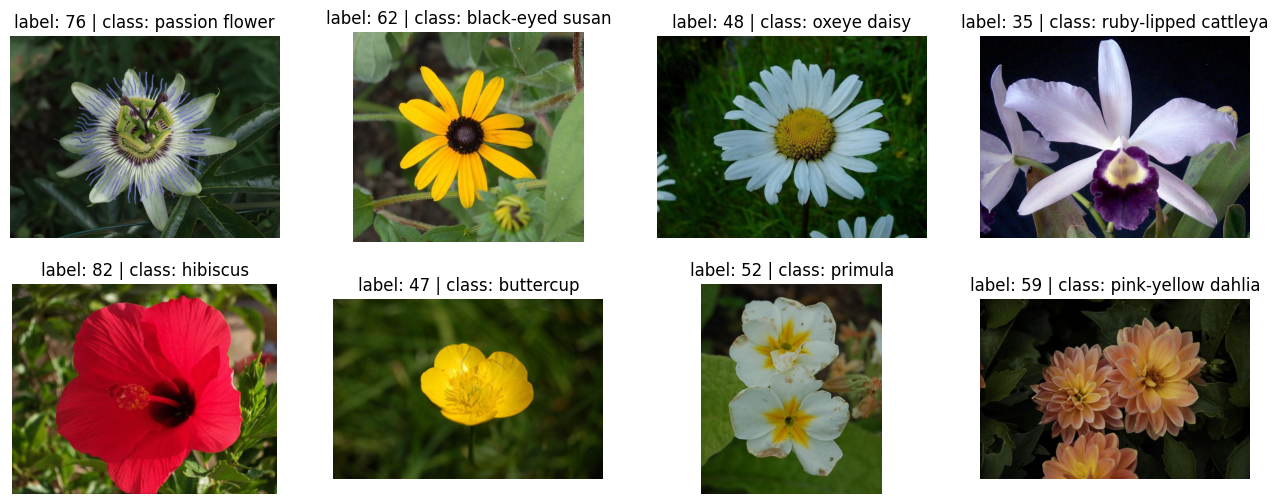

In [ ]:
# Visualize eight random images
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 6))
image_num = random.sample(range(1, len(labels)), k=8) # there are 8198 images
# print(image_num)
for i in range(2):
  for j in range(4):
    image = skio.imread(os.path.join(data_path, f'image_{image_num[i*4+j]:05}.jpg')) # ':05' creates five zeros
    # print(f'image_{image_num[i*4+j]:05}.jpg')
    ax[i, j].imshow(image)
    ax[i, j].axis('off')
    ax[i, j].set_title(f'label: {labels[image_num[i*4+j]]} | class: {class_names[str(labels[image_num[i*4+j]])]}')

### 2.4 Prepare a subset of the target classes

Flower-102 dataset has 102 different classes of flowers.

But our target classes will be: **fire lily**, **peruvian lily**, **sword lily**, **tiger lily** and **water lily**.

So, **five classes** in total.


In [ ]:
# Create a custom list with the target classes
target_names = ["fire lily",
                "peruvian lily",
                "sword lily",
                "tiger lily",
                "water lily"]

In [ ]:
# Check the number of the target classes
num_classes = len(target_names)
num_classes

5

In [ ]:
# Create a custom dictionary with the target classes
lily_names = {"0": "fire lily",
              "1": "peruvian lily",
              "2": "sword lily",
              "3": "tiger lily",
              "4": "water lily"}

In [ ]:
# Remove dir
# !rm -rf /data

### 3. Dividing the Data into Train, Test, Validation sets

[A link](https://programmersought.com/article/740211421014/) to the dataset split implementation.

### 3.1 Creating a new folder FLOWERS-5 to store Train, Validation, Test

In [ ]:
# Setup path to data folder
image_path = data_dir / "flowers-102/flowers-5"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory already exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

Did not find ../data/flowers-102/flowers-5 directory, creating one...


### 3.2 Using data split's SETID.mat to divide Train, Validation, Test

In [ ]:
setid = scp.loadmat(data_dir / 'flowers-102/setid.mat') # get a dict with 'trnid', 'valid', 'tstid' keys

validation = np.array(setid['valid'][0]) - 1
# print(setid['valid'][0])
np.random.shuffle(validation)

train = np.array(setid['trnid'][0]) - 1
np.random.shuffle(train)

test = np.array(setid['tstid'][0]) - 1
np.random.shuffle(test)

In [ ]:
len(train), len(validation), len(test)

(1020, 1020, 6149)

In [ ]:
# The test dataset is bigger than the train dataset (6149 images vs 1020 images)
# Therefore, swap out the train dataset with the test dataset
train, test = test, train
len(train), len(test)

(6149, 1020)

### 3.3 Move Data to FLOWER_DIR

In [ ]:
flower_dir = []

for img in os.listdir(data_dir / 'flowers-102/jpg'):
    flower_dir.append(os.path.join(data_dir / 'flowers-102/jpg', img))
flower_dir.sort()

In [ ]:
flower_dir[:5]

['../data/flowers-102/jpg/image_00001.jpg',
 '../data/flowers-102/jpg/image_00002.jpg',
 '../data/flowers-102/jpg/image_00003.jpg',
 '../data/flowers-102/jpg/image_00004.jpg',
 '../data/flowers-102/jpg/image_00005.jpg']

In [ ]:
len(flower_dir)

8189

### 3.4 Get LABELS according to the value of IMAGELABELS.mat

In [ ]:
# Get labels
# labels = scp.loadmat(data_dir / 'flowers-102/imagelabels.mat')
# labels = np.array(labels['labels'][0]) - 1
print("labels:", labels)

labels: [76 76 76 ... 61 61 61]


### 3.5 Put the TRAIN data into the TRAIN folder according to the value of SETID.mat

In [ ]:
des_folder_train = data_dir / 'flowers-102/flowers-5/train'

for tid in train:
  # Open the image
  img = Image.open(flower_dir[tid])
  print(img)

  img = img.resize((256, 256), Image.Resampling.LANCZOS)
  lable = labels[tid]

  path = flower_dir[tid]
  print("path:", path)

  base_path = os.path.basename(path)
  print("base_path:", base_path)

  classes = class_names[str(lable)]

  if classes in target_names:
    class_path = os.path.join(des_folder_train, classes)

    if not os.path.exists(class_path):
      os.makedirs(class_path)
    print("class_path:", class_path)

    despath = os.path.join(class_path, base_path)
    print("despath:", despath)

    img.save(despath)

Выходные данные были обрезаны до нескольких последних строк (5000).
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=667x500 at 0x7B317E8809D0>
path: ../data/flowers-102/jpg/image_04520.jpg
base_path: image_04520.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=752x500 at 0x7B317EA3DA50>
path: ../data/flowers-102/jpg/image_07271.jpg
base_path: image_07271.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=620x500 at 0x7B317EA3D750>
path: ../data/flowers-102/jpg/image_02531.jpg
base_path: image_02531.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=732x500 at 0x7B317E86F850>
path: ../data/flowers-102/jpg/image_05063.jpg
base_path: image_05063.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=724x500 at 0x7B317EA3D750>
path: ../data/flowers-102/jpg/image_04569.jpg
base_path: image_04569.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=751x500 at 0x7B317EA3FAF0>
path: ../data/flowers-102/jpg/image_04748.jpg
base_path: image_04748.jpg
<P

### 3.6 Put the VALIDATION data into the VALIDATION folder according to the value of SETID.mat


In [ ]:
des_folder_validation = data_dir / 'flowers-102/flowers-5/validation'

for tid in validation:
  # Open the image
  img = Image.open(flower_dir[tid])
  print(img)

  img = img.resize((256, 256), Image.Resampling.LANCZOS)
  lable = labels[tid]

  path = flower_dir[tid]
  print("path:", path)

  base_path = os.path.basename(path)
  print("base_path:", base_path)

  classes = class_names[str(lable)]

  if classes in target_names:
    class_path = os.path.join(des_folder_validation, classes)

    if not os.path.exists(class_path):
      os.makedirs(class_path)
    print("class_path:", class_path)

    despath = os.path.join(class_path, base_path)
    print("despath:", despath)

    img.save(despath)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=648x500 at 0x7B317E86CB80>
path: ../data/flowers-102/jpg/image_06668.jpg
base_path: image_06668.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=729x500 at 0x7B317EA3CDF0>
path: ../data/flowers-102/jpg/image_03912.jpg
base_path: image_03912.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=642x500 at 0x7B317EA3C460>
path: ../data/flowers-102/jpg/image_04698.jpg
base_path: image_04698.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=705x500 at 0x7B317EA3F160>
path: ../data/flowers-102/jpg/image_04559.jpg
base_path: image_04559.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=669x500 at 0x7B317EA3D990>
path: ../data/flowers-102/jpg/image_06904.jpg
base_path: image_06904.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=667x500 at 0x7B317EA3F160>
path: ../data/flowers-102/jpg/image_02227.jpg
base_path: image_02227.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x751 at 0x7B

### 3.7 Put the TEST data into the TEST folder according to the value of SETID.mat

In [ ]:
des_folder_test = data_dir / 'flowers-102/flowers-5/test'

for tid in test:
  # Open the image
  img = Image.open(flower_dir[tid])
  print(img)

  img = img.resize((256, 256), Image.Resampling.LANCZOS)
  lable = labels[tid]

  path = flower_dir[tid]
  print("path:", path)

  base_path = os.path.basename(path)
  print("base_path:", base_path)

  classes = class_names[str(lable)]

  if classes in target_names:
    class_path = os.path.join(des_folder_test, classes)

    if not os.path.exists(class_path):
      os.makedirs(class_path)
    print("class_path:", class_path)

    despath = os.path.join(class_path, base_path)
    print("despath:", despath)

    img.save(despath)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=668x500 at 0x7B317EA3E7A0>
path: ../data/flowers-102/jpg/image_06689.jpg
base_path: image_06689.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=701x500 at 0x7B317EA3E1A0>
path: ../data/flowers-102/jpg/image_03294.jpg
base_path: image_03294.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=806x500 at 0x7B317EA3E7A0>
path: ../data/flowers-102/jpg/image_01655.jpg
base_path: image_01655.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=624x500 at 0x7B317EA3DA50>
path: ../data/flowers-102/jpg/image_05573.jpg
base_path: image_05573.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x523 at 0x7B317EA3D7B0>
path: ../data/flowers-102/jpg/image_07195.jpg
base_path: image_07195.jpg
class_path: ../data/flowers-102/flowers-5/test/tiger lily
despath: ../data/flowers-102/flowers-5/test/tiger lily/image_07195.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x883 at 0x7B317EA3C670>
path: ../data/

### 3.8  Setup TRAIN, VALID and TESTING paths

In [ ]:
image_path

PosixPath('../data/flowers-102/flowers-5')

In [ ]:
# Create paths to our training, validation and test directories
train_dir = image_path / "train"
valid_dir = image_path / "validation"
test_dir = image_path / "test"

train_dir, valid_dir, test_dir

(PosixPath('../data/flowers-102/flowers-5/train'),
 PosixPath('../data/flowers-102/flowers-5/validation'),
 PosixPath('../data/flowers-102/flowers-5/test'))

### 3.9 Walk through each directory

In [ ]:
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} files/images in '{dirpath}'.")

In [ ]:
walk_through_dir(data_dir)

There are 1 directories and 1 files/images in '../data'.
There are 2 directories and 3 files/images in '../data/flowers-102'.
There are 0 directories and 8189 files/images in '../data/flowers-102/jpg'.
There are 3 directories and 0 files/images in '../data/flowers-102/flowers-5'.
There are 5 directories and 0 files/images in '../data/flowers-102/flowers-5/validation'.
There are 0 directories and 10 files/images in '../data/flowers-102/flowers-5/validation/peruvian lily'.
There are 0 directories and 10 files/images in '../data/flowers-102/flowers-5/validation/fire lily'.
There are 0 directories and 10 files/images in '../data/flowers-102/flowers-5/validation/tiger lily'.
There are 0 directories and 10 files/images in '../data/flowers-102/flowers-5/validation/water lily'.
There are 0 directories and 10 files/images in '../data/flowers-102/flowers-5/validation/sword lily'.
There are 5 directories and 0 files/images in '../data/flowers-102/flowers-5/train'.
There are 0 directories and 62 f

### 3.10 Visualize a random image from the train dataset

Random image path: ../data/flowers-102/flowers-5/train/water lily/image_00324.jpg
Image class: water lily
Image height: 256
Image width: 256


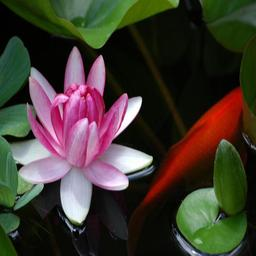

In [ ]:
# Set image_path
image_path = data_dir / "flowers-102/flowers-5"

# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg")) # */*/* -> f.e.: train/fire lily/image.jpg

# Get random image path
random_image_path = random.choice(image_path_list)
# print(random_image_path)

# Get image class from path name
image_class = random_image_path.parent.stem
# print(image_class)

# Open image
img = Image.open(random_image_path)

# Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

## 4. Using a Pre-trained Model DenseNet161 to classify the images


In [ ]:
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

[INFO] Couldn't find torchinfo... installing it.


### 4.1 Creating an DenseNet161 feature extractor

In [ ]:
# Check out DenseNet161 classifier layer
densenet161 = torchvision.models.densenet161()
densenet161.classifier

Linear(in_features=2208, out_features=1000, bias=True)

In [ ]:
# Print DenseNet161 model summary BEFORE freezing all base layers in the "features" section of the model
summary(model=densenet161,
input_size=(1, 3, 224, 224),
col_names=["input_size", "output_size", "num_params", "trainable"],
col_width=20,
row_settings=["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
DenseNet (DenseNet)                           [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                       [1, 3, 224, 224]     [1, 2208, 7, 7]      --                   True
│    └─Conv2d (conv0)                         [1, 3, 224, 224]     [1, 96, 112, 112]    14,112               True
│    └─BatchNorm2d (norm0)                    [1, 96, 112, 112]    [1, 96, 112, 112]    192                  True
│    └─ReLU (relu0)                           [1, 96, 112, 112]    [1, 96, 112, 112]    --                   --
│    └─MaxPool2d (pool0)                      [1, 96, 112, 112]    [1, 96, 56, 56]      --                   --
│    └─_DenseBlock (denseblock1)              [1, 96, 56, 56]      [1, 384, 56, 56]     --                   True
│    │    └─_DenseLayer (denselayer1)         [1, 96, 56, 56]      [1, 48, 56, 56]     

In [ ]:
def create_densenet161_model(num_classes:int=5, # default value
                             seed:int=42):
    """Creates a DenseNet161 feature extractor model and transforms.
    """
    # Create pretrained weights, transforms and model
    weights = torchvision.models.DenseNet161_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.densenet161(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Linear(in_features=2208, out_features=num_classes)

    return model, transforms

In [ ]:
densenet161, densenet161_transforms = create_densenet161_model(num_classes=num_classes,
                                                               seed=42)
# densenet161, densenet161_transforms

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:00<00:00, 131MB/s]


In [ ]:
# Check out DenseNet121 classifier layer
densenet161.classifier

Linear(in_features=2208, out_features=5, bias=True)

In [ ]:
# Print DenseNet161 model summary AFTER changing the output classifier layer
summary(model=densenet161,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
DenseNet (DenseNet)                           [1, 3, 224, 224]     [1, 5]               --                   Partial
├─Sequential (features)                       [1, 3, 224, 224]     [1, 2208, 7, 7]      --                   False
│    └─Conv2d (conv0)                         [1, 3, 224, 224]     [1, 96, 112, 112]    (14,112)             False
│    └─BatchNorm2d (norm0)                    [1, 96, 112, 112]    [1, 96, 112, 112]    (192)                False
│    └─ReLU (relu0)                           [1, 96, 112, 112]    [1, 96, 112, 112]    --                   --
│    └─MaxPool2d (pool0)                      [1, 96, 112, 112]    [1, 96, 56, 56]      --                   --
│    └─_DenseBlock (denseblock1)              [1, 96, 56, 56]      [1, 384, 56, 56]     --                   False
│    │    └─_DenseLayer (denselayer1)         [1, 96, 56, 56]      [1, 48, 56, 5

### 4.2 Creating DataLoaders for DenseNet161 model

In [ ]:
# Helper Function 1

BATCH_SIZE = 16
NUM_WORKERS = os.cpu_count()

def create_dataloaders(train_dir: str,
                       valid_dir: str,
                       transform: transforms.Compose,
                       batch_size: int,
                       num_workers: int=NUM_WORKERS):
  """Creates training and validating DataLoaders.

  Takes in a training directory and validating directory
  path and turns them into PyTorch Datasets and then into PyTorch DataLoaders.

  Returns:
    A tuple of (train_dataloader, valid_dataloader).
  """

  # Use ImageFolder to create datasets
  train_data = datasets.ImageFolder(root=train_dir, transform=transform)
  valid_data = datasets.ImageFolder(root=valid_dir, transform=transform)

  # Turn images into data loaders
  train_dataloader = DataLoader(dataset=train_data,
                                batch_size=batch_size,
                                num_workers=num_workers,
                                shuffle=True,
                                pin_memory=True)

  valid_dataloader = DataLoader(dataset=valid_data,
                                batch_size=batch_size,
                                num_workers=num_workers,
                                shuffle=False,
                                pin_memory=True)

  return train_dataloader, valid_dataloader

In [ ]:
# Setup DenseNet161 DataLoaders
train_dataloader_densenet161, valid_dataloader_densenet161 = create_dataloaders(train_dir=train_dir,
                                                                                valid_dir=valid_dir,
                                                                                transform=densenet161_transforms,
                                                                                batch_size=BATCH_SIZE)

train_dataloader_densenet161, valid_dataloader_densenet161

(<torch.utils.data.dataloader.DataLoader at 0x7b3180c386a0>,
 <torch.utils.data.dataloader.DataLoader at 0x7b3180c38640>)

In [ ]:
len(train_dataloader_densenet161), len(valid_dataloader_densenet161)

(25, 4)

In [ ]:
X, y = next(iter(train_dataloader_densenet161))
X.shape, y.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

### 4.3 Train the output layer of DenseNet161

In [ ]:
# Helper Function 2

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):

  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and average accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc

In [ ]:
# Helper function 3

def valid_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device: torch.device):

  # Put model in eval mode
  model.eval()

  # Setup the valid loss and valid accuracy values
  valid_loss, valid_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      valid_pred_logits = model(X)
      # print(test_pred_logits)

      # 2. Calculuate and accumulate loss
      loss = loss_fn(valid_pred_logits, y)
      valid_loss += loss.item()

      # Calculate and accumulate accuracy
      valid_pred_labels = valid_pred_logits.argmax(dim=1)
      valid_acc += ((valid_pred_labels == y).sum().item()/len(valid_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  valid_loss = valid_loss / len(dataloader)
  valid_acc = valid_acc / len(dataloader)

  return valid_loss, valid_acc

In [ ]:
# Helper function 4

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          valid_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          device: torch.device,
          epochs: int = 1):

  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "valid_loss": [],
             "valid_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    # Validation step
    valid_loss, valid_acc = valid_step(model=model,
                                       dataloader=valid_dataloader,
                                       loss_fn=loss_fn,
                                       device=device)

    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"valid_loss: {valid_loss:.4f} | "
          f"valid_acc: {valid_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["valid_loss"].append(valid_loss)
    results["valid_acc"].append(valid_acc)

  # Return the results dictionary
  return results

In [ ]:
# Setup optimizer
optimizer = torch.optim.Adam(params=densenet161.parameters(),
                             lr=0.001)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Number of epochs
NUM_EPOCHS = 3

# Start the timer
start_time = timer()

# Setup training and save the results
densenet161_results = train(model=densenet161,
                            train_dataloader=train_dataloader_densenet161,
                            valid_dataloader=valid_dataloader_densenet161,
                            optimizer=optimizer,
                            loss_fn=loss_fn,
                            epochs=NUM_EPOCHS,
                            device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0945 | train_acc: 0.5875 | valid_loss: 0.7679 | valid_acc: 0.8125
Epoch: 2 | train_loss: 0.5276 | train_acc: 0.8550 | valid_loss: 0.3854 | valid_acc: 1.0000
Epoch: 3 | train_loss: 0.3367 | train_acc: 0.9250 | valid_loss: 0.2322 | valid_acc: 1.0000
[INFO] Total training time: 904.503 seconds


### 4.4 Plot the Loss and Accuracy curves of DenseNet161

In [ ]:
# Helper Function 5

def plot_loss_curves(results):
  """Plots training curves of a results dictionary.
  """

  # Get the loss values of the results dictionary (training and test)
  loss = results['train_loss']
  valid_loss = results['valid_loss']

  # Get the accuracy values of the results dictionary (training and test)
  accuracy = results['train_acc']
  valid_accuracy = results['valid_acc']

  # Figure out how many epochs there were
  epochs = range(len(results['train_loss']))

  # Setup a plot
  plt.figure(figsize=(15, 7))

  # Plot loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, np.array(torch.tensor(loss).cpu().numpy()), label='train_loss')
  plt.plot(epochs, np.array(torch.tensor(valid_loss).cpu().numpy()), label='valid_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, np.array(torch.tensor(accuracy).cpu().numpy()), label='train_accuracy')
  plt.plot(epochs, np.array(torch.tensor(valid_accuracy).cpu().numpy()), label='valid_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

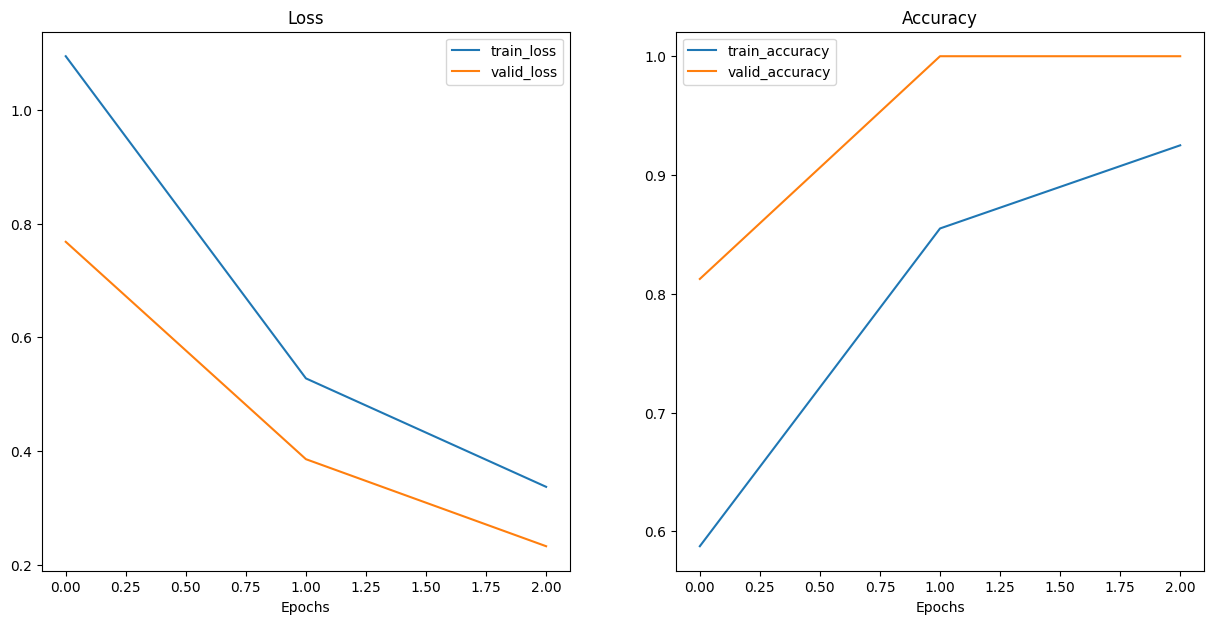

In [ ]:
plot_loss_curves(densenet161_results)

### 4.5  Saving DenseNet161 feature extractor

In [ ]:
# Helper function 8

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
  """Saves a PyTorch model to a target directory.
  """
  # Create target directory
  target_dir_path = pathlib.Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  # Create model save path
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

In [ ]:
save_model(model=densenet161,
           target_dir="models",
           model_name="01_pretrained_densenet161_feature_extractor_flowers5.pth")

[INFO] Saving model to: models/01_pretrained_densenet161_feature_extractor_flowers5.pth


### 4.6 Checking the size of DenseNet161 feature extractor

In [ ]:
# Get the model size in bytes then convert to megabytes
pretrained_densenet161_model_size = pathlib.Path("models/01_pretrained_densenet161_feature_extractor_flowers5.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained DenseNet161 feature extractor model size: {pretrained_densenet161_model_size} MB")

Pretrained DenseNet161 feature extractor model size: 102 MB


In [ ]:
# Count number of parameters in DenseNet161
densenet161_total_params = sum(torch.numel(param) for param in densenet161.parameters())
densenet161_total_params

26483045

In [ ]:
# Create DenseNet161 statistics dictionary
densenet161_stats = {"valid_loss": densenet161_results["valid_loss"][-1],
                     "valid_acc": densenet161_results["valid_acc"][-1],
                     "number_of_parameters": densenet161_total_params,
                     "model_size (MB)": pretrained_densenet161_model_size}

densenet161_stats

{'valid_loss': 0.2322217170149088,
 'valid_acc': 1.0,
 'number_of_parameters': 26483045,
 'model_size (MB)': 102}

### 4.7 Making predictions with our trained model and timing it

In [ ]:
# Get all valid data paths
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {valid_dir}")
valid_data_paths = list(pathlib.Path(valid_dir).glob("*/*.jpg"))
valid_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: ../data/flowers-102/flowers-5/validation


[PosixPath('../data/flowers-102/flowers-5/validation/peruvian lily/image_04258.jpg'),
 PosixPath('../data/flowers-102/flowers-5/validation/peruvian lily/image_04260.jpg'),
 PosixPath('../data/flowers-102/flowers-5/validation/peruvian lily/image_04261.jpg'),
 PosixPath('../data/flowers-102/flowers-5/validation/peruvian lily/image_04323.jpg'),
 PosixPath('../data/flowers-102/flowers-5/validation/peruvian lily/image_04296.jpg')]

In [ ]:
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
  """
  Creates a list of dictionaries with image path, truth label, prediction,
  prediction probability and prediction time.
  """

  # 1. Create an empty list to store prediction dictionaries
  pred_list = []

  # 2. Loop through target paths
  for path in tqdm(paths):

    # 3. Create empty dictionary to store prediction information for each sample
    pred_dict = {}

    # 4. Get the sample path and ground truth class name
    pred_dict["image_path"] = path
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    # 5. Start the prediction timer
    start_time = timer()

    # 6. Open image path
    img = Image.open(path)

    # 7. Transform the image, add batch dimension and put image on target device
    transformed_image = transform(img).unsqueeze(0).to(device)

    # 8. Prepare model for inference by sending it to target device and turning on eval() mode
    model.to(device)
    model.eval()

    # 9. Get prediction probability, predicition label and prediction class
    with torch.inference_mode():
      pred_logit = model(transformed_image) # perform inference on target sample
      pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
      pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
      pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

      # 10. Make sure things in the dictionary are on CPU (required for inspecting predictions later on)
      pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
      pred_dict["pred_class"] = pred_class

      # 11. End the timer and calculate time per pred
      end_time = timer()
      pred_dict["time_for_pred"] = round(end_time-start_time, 4)

    # 12. Does the pred match the true label?
    pred_dict["correct"] = class_name == pred_class

    # 13. Add the dictionary to the list of preds
    pred_list.append(pred_dict)

  # 14. Return list of prediction dictionaries
  return pred_list

In [ ]:
# Make predictions across test dataset with DenseNet161
densenet161_valid_pred_dicts = pred_and_store(paths=valid_data_paths,
                                              model=densenet161,
                                              transform=densenet161_transforms,
                                              class_names=target_names,
                                              device="cpu") # make predictions on CPU

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# Inspect the first 2 prediction dictionaries
densenet161_valid_pred_dicts[:2]

[{'image_path': PosixPath('../data/flowers-102/flowers-5/validation/peruvian lily/image_04258.jpg'),
  'class_name': 'peruvian lily',
  'pred_prob': 0.6068,
  'pred_class': 'peruvian lily',
  'time_for_pred': 0.46,
  'correct': True},
 {'image_path': PosixPath('../data/flowers-102/flowers-5/validation/peruvian lily/image_04260.jpg'),
  'class_name': 'peruvian lily',
  'pred_prob': 0.8334,
  'pred_class': 'peruvian lily',
  'time_for_pred': 0.4041,
  'correct': True}]

In [ ]:
# Turn the valid_pred_dicts into a DataFrame
densenet161_valid_pred_df = pd.DataFrame(densenet161_valid_pred_dicts)
densenet161_valid_pred_df

image_path     class_name  \
0   ../data/flowers-102/flowers-5/validation/peruv...  peruvian lily   
1   ../data/flowers-102/flowers-5/validation/peruv...  peruvian lily   
2   ../data/flowers-102/flowers-5/validation/peruv...  peruvian lily   
3   ../data/flowers-102/flowers-5/validation/peruv...  peruvian lily   
4   ../data/flowers-102/flowers-5/validation/peruv...  peruvian lily   
5   ../data/flowers-102/flowers-5/validation/peruv...  peruvian lily   
6   ../data/flowers-102/flowers-5/validation/peruv...  peruvian lily   
7   ../data/flowers-102/flowers-5/validation/peruv...  peruvian lily   
8   ../data/flowers-102/flowers-5/validation/peruv...  peruvian lily   
9   ../data/flowers-102/flowers-5/validation/peruv...  peruvian lily   
10  ../data/flowers-102/flowers-5/validation/fire ...      fire lily   
11  ../data/flowers-102/flowers-5/validation/fire ...      fire lily   
12  ../data/flowers-102/flowers-5/validation/fire ...      fire lily   
13  ../data/flowers-102/flowers-5/validation/fire ...      fire lily   
14  ../data/flowers-102/flowers-5/validation/fire ...      fire lily   
15  ../data/flowers-102/flowers-5/validation/fire ...      fire lily   
16  ../data/flowers-102/flowers-5/validation/fire ...      fire lily   
17  ../data/flowers-102/flowers-5/validation/fire ...      fire lily   
18  ../data/flowers-102/flowers-5/validation/fire ...      fire lily   
19  ../data/flowers-102/flowers-5/validation/fire ...      fire lily   
20  ../data/flowers-102/flowers-5/validation/tiger...     tiger lily   
21  ../data/flowers-102/flowers-5/validation/tiger...     tiger lily   
22  ../data/flowers-102/flowers-5/validation/tiger...     tiger lily   
23  ../data/flowers-102/flowers-5/validation/tiger...     tiger lily   
24  ../data/flowers-102/flowers-5/validation/tiger...     tiger lily   
25  ../data/flowers-102/flowers-5/validation/tiger...     tiger lily   
26  ../data/flowers-102/flowers-5/validation/tiger...     tiger lily   
27  ../data/flowers-102/flowers-5/validation/tiger...     tiger lily   
28  ../data/flowers-102/flowers-5/validation/tiger...     tiger lily   
29  ../data/flowers-102/flowers-5/validation/tiger...     tiger lily   
30  ../data/flowers-102/flowers-5/validation/water...     water lily   
31  ../data/flowers-102/flowers-5/validation/water...     water lily   
32  ../data/flowers-102/flowers-5/validation/water...     water lily   
33  ../data/flowers-102/flowers-5/validation/water...     water lily   
34  ../data/flowers-102/flowers-5/validation/water...     water lily   
35  ../data/flowers-102/flowers-5/validation/water...     water lily   
36  ../data/flowers-102/flowers-5/validation/water...     water lily   
37  ../data/flowers-102/flowers-5/validation/water...     water lily   
38  ../data/flowers-102/flowers-5/validation/water...     water lily   
39  ../data/flowers-102/flowers-5/validation/water...     water lily   
40  ../data/flowers-102/flowers-5/validation/sword...     sword lily   
41  ../data/flowers-102/flowers-5/validation/sword...     sword lily   
42  ../data/flowers-102/flowers-5/validation/sword...     sword lily   
43  ../data/flowers-102/flowers-5/validation/sword...     sword lily   
44  ../data/flowers-102/flowers-5/validation/sword...     sword lily   
45  ../data/flowers-102/flowers-5/validation/sword...     sword lily   
46  ../data/flowers-102/flowers-5/validation/sword...     sword lily   
47  ../data/flowers-102/flowers-5/validation/sword...     sword lily   
48  ../data/flowers-102/flowers-5/validation/sword...     sword lily   
49  ../data/flowers-102/flowers-5/validation/sword...     sword lily   

    pred_prob     pred_class  time_for_pred  correct  
0      0.6068  peruvian lily         0.4600     True  
1      0.8334  peruvian lily         0.4041     True  
2      0.8657  peruvian lily         0.4370     True  
3      0.5472  peruvian lily         0.4280     True  
4      0.8334  peruvian lily         0.4336     True  
5      0.8545  peruvian lily         0.4

In [ ]:
# Check the number of correct predictions
densenet161_valid_pred_df.correct.value_counts()

correct
True    50
Name: count, dtype: int64

In [ ]:
# Find the average time per prediction
densenet161_average_time_per_pred = round(densenet161_valid_pred_df.time_for_pred.mean(), 4)
print(f"DenseNet161 average time per prediction: {densenet161_average_time_per_pred} seconds")

DenseNet161 average time per prediction: 0.5047 seconds


In [ ]:
# Add DenseNet161 average prediction time to stats dictionary
densenet161_stats["time_per_pred_cpu"] = densenet161_average_time_per_pred
densenet161_stats

{'valid_loss': 0.2322217170149088,
 'valid_acc': 1.0,
 'number_of_parameters': 26483045,
 'model_size (MB)': 102,
 'time_per_pred_cpu': 0.5047}

### 4.9 Make a confusion matrix with the validation predictions and the truth labels

In [ ]:
try:
  import torchmetrics, mlxtend
  print(f'mlxtend version: {mlxtend.__version__}')
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f'mlxtend version: {mlxtend.__version__}')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 19.1 MB/s eta 0:00:00
mlxtend version: 0.23.1


In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

In [ ]:
# Helper function 6

def make_preds_whole_dataset(model: torch.nn.Module,
                             data_loader: torch.utils.data.DataLoader):
  """
  Makes predictions across the whole validation dataset
  """

  y_preds = []

  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      X, y = X.to(device), y.to(device)

      # Get logits
      test_logit = model(X)
      # Logits -> Prediction probabilities
      y_pred_probs = torch.softmax(test_logit, dim=1)
      # Prediction probabilities -> Prediction labels
      y_pred = torch.argmax(y_pred_probs, dim=1)

      y_preds.append(y_pred)

  y_pred_tensor = torch.cat(y_preds).cpu()

  return y_pred_tensor

In [ ]:
# Densenet161 Model
make_preds_whole_dataset(model=densenet161,
                         data_loader=valid_dataloader_densenet161)

  0%|          | 0/4 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4])

In [ ]:
true_labels = torch.cat([y for X, y in valid_dataloader_densenet161])
true_labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4])

In [ ]:
# Setup confusion instance and compare predictions to target predictions
confmat = ConfusionMatrix(num_classes=num_classes, task='MULTICLASS')
confmat_tensor = confmat(preds=make_preds_whole_dataset(model=densenet161,
                                                        data_loader=valid_dataloader_densenet161),
                         target=true_labels)

confmat_tensor

  0%|          | 0/4 [00:00<?, ?it/s]

tensor([[10,  0,  0,  0,  0],
        [ 0, 10,  0,  0,  0],
        [ 0,  0, 10,  0,  0],
        [ 0,  0,  0, 10,  0],
        [ 0,  0,  0,  0, 10]])

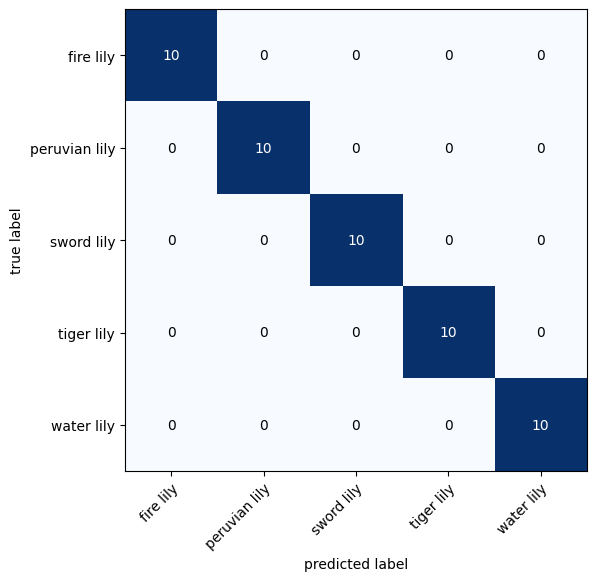

In [ ]:
# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=target_names,
    figsize=(6, 6)
)

## 5. DenseNet161 Results

In [ ]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([densenet161_stats])

# Add number of epochs
df['num_epochs'] = NUM_EPOCHS

# Add column for model names
df["model"] = ["DenseNet161"]

# Convert accuracy to percentages
df["valid_acc"] = round(df["valid_acc"] * 100, 2)

df

valid_loss  valid_acc  number_of_parameters  model_size (MB)  \
0    0.232222      100.0              26483045              102   

   time_per_pred_cpu  num_epochs        model  
0             0.5047           3  DenseNet161

## 6 Make predictions on the test data and plot some random images

In [ ]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []

  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare sample - add an extra dimension and send sample to device
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # Forward pass
      pred_logit = model(sample)
      # Get prediction probability (logit -> prediction probability)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
      # Get pred_prob off GPU for further calculations
      pred_probs.append(pred_prob.cpu())

  # Stack the pred_probs to turn list into a tensor
  return torch.stack(pred_probs)

In [ ]:
# Prepare test_data
transform = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])
test_data = datasets.ImageFolder(root=test_dir, transform=transform)
test_data

Dataset ImageFolder
    Number of datapoints: 50
    Root location: ../data/flowers-102/flowers-5/test
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
import random

# Create a dictionary: {class: index}
class_to_index = {'fire lily': 0,
                  'peruvian lily': 1,
                  'sword lily': 2,
                  'tiger lily': 3,
                  'water lily': 4}

test_samples = []
test_labels = []

# Get all test data paths
test_data_paths = list(pathlib.Path(test_dir).glob("*/*.jpg"))
# labels = [path.parent.stem for path in test_data_paths]

# for sample, label in random.sample(list(test_data_trained), k=20):
for path in random.sample(test_data_paths, k=12):
  # Get label
  label = path.parent.stem
  test_label = class_to_index[label]
  test_labels.append(test_label)

  # 1. Load in image and convert the tensor values to float32
  target_image = torchvision.io.read_image(str(path))

  # 2. Divide the image pixel values by 255 to get them between [0, 1]
  target_image = target_image / 255

  # 3. Transform the image
  new_transform = transforms.Compose([
            transforms.Resize(size=(224, 224)),
        ])

  transformed_image = new_transform(target_image)

  # 4. Add to the list
  test_samples.append(transformed_image)

print(test_samples[0].shape)
print(test_samples[0].dtype)
print(test_labels[:5])

torch.Size([3, 224, 224])
torch.float32
[4, 3, 3, 2, 4]


In [ ]:
# Make predictions on test samples with DenseNet161 model
pred_probs = make_predictions(model=densenet161,
                              data=test_samples)

# View first three prediction probabilities list
pred_probs[:3]

tensor([[0.0189, 0.0112, 0.0231, 0.0056, 0.9413],
        [0.0464, 0.1191, 0.1975, 0.4644, 0.1725],
        [0.0480, 0.0691, 0.0340, 0.8271, 0.0217]])

In [ ]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([4, 3, 3, 2, 4, 3, 3, 3, 0, 2, 4, 0])

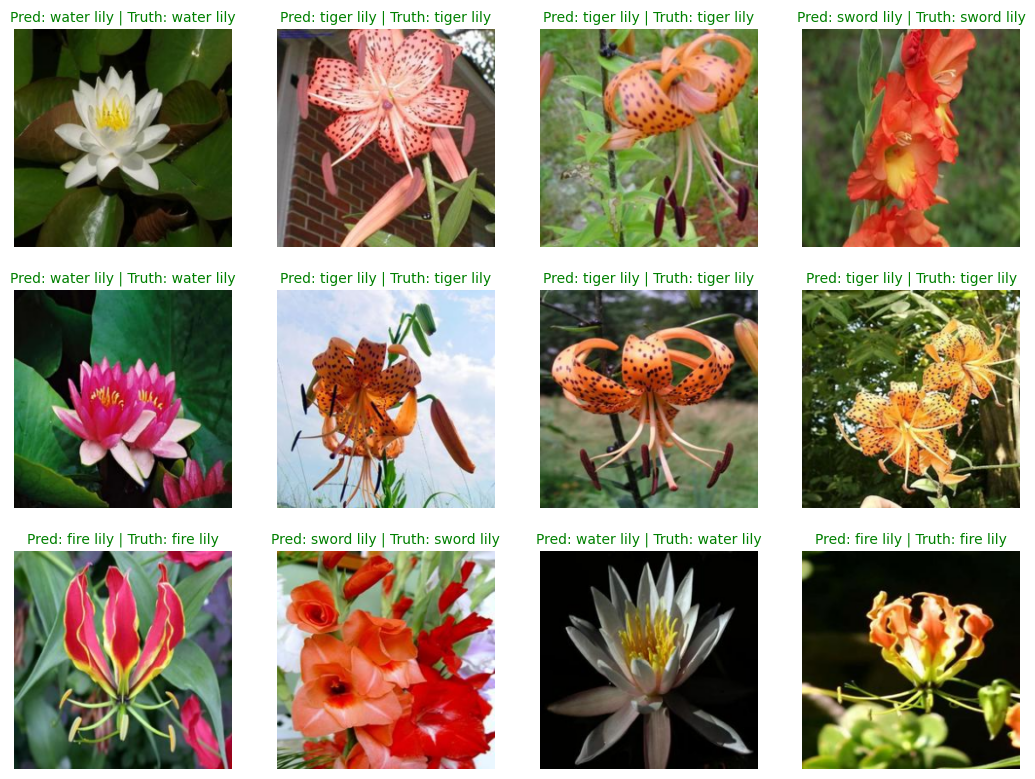

In [ ]:
# Plot predictions
plt.figure(figsize=(13, 13))
nrows = 4
ncols = 4

for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1) # i+1 -> it can't start with 0

  # Plot the target image
  plt.imshow((sample.numpy() * 255).astype(np.uint8).transpose(1, 2, 0))

  # Find the prediction label
  pred_label = target_names[pred_classes[i]]

  # Get the truth label
  truth_label = target_names[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False)

## 7. Make Predictions on a Custom Image

In [ ]:
# Setup custom image path
custom_image_path = data_dir / 'peruvian_liy.jpg'
custom_image_path

PosixPath('../data/peruvian_liy.jpg')

In [ ]:
# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# Print out image data
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[29, 29, 30,  ..., 41, 41, 41],
         [31, 32, 32,  ..., 41, 41, 41],
         [35, 35, 35,  ..., 41, 42, 42],
         ...,
         [17, 17, 17,  ..., 30, 29, 29],
         [17, 17, 17,  ..., 30, 29, 29],
         [17, 17, 17,  ..., 30, 29, 29]],

        [[42, 42, 43,  ..., 69, 69, 69],
         [44, 45, 45,  ..., 69, 69, 69],
         [46, 46, 46,  ..., 69, 70, 70],
         ...,
         [18, 18, 18,  ..., 20, 19, 19],
         [18, 18, 18,  ..., 20, 19, 19],
         [18, 18, 18,  ..., 20, 19, 19]],

        [[35, 35, 36,  ..., 21, 21, 21],
         [37, 38, 38,  ..., 21, 21, 21],
         [40, 40, 40,  ..., 20, 21, 21],
         ...,
         [13, 13, 13,  ..., 21, 20, 20],
         [13, 13, 13,  ..., 21, 20, 20],
         [13, 13, 13,  ..., 21, 20, 20]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 750, 1000])

Custom image dtype: torch.uint8


In [ ]:
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255.

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.1137, 0.1137, 0.1176,  ..., 0.1608, 0.1608, 0.1608],
         [0.1216, 0.1255, 0.1255,  ..., 0.1608, 0.1608, 0.1608],
         [0.1373, 0.1373, 0.1373,  ..., 0.1608, 0.1647, 0.1647],
         ...,
         [0.0667, 0.0667, 0.0667,  ..., 0.1176, 0.1137, 0.1137],
         [0.0667, 0.0667, 0.0667,  ..., 0.1176, 0.1137, 0.1137],
         [0.0667, 0.0667, 0.0667,  ..., 0.1176, 0.1137, 0.1137]],

        [[0.1647, 0.1647, 0.1686,  ..., 0.2706, 0.2706, 0.2706],
         [0.1725, 0.1765, 0.1765,  ..., 0.2706, 0.2706, 0.2706],
         [0.1804, 0.1804, 0.1804,  ..., 0.2706, 0.2745, 0.2745],
         ...,
         [0.0706, 0.0706, 0.0706,  ..., 0.0784, 0.0745, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0784, 0.0745, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0784, 0.0745, 0.0745]],

        [[0.1373, 0.1373, 0.1412,  ..., 0.0824, 0.0824, 0.0824],
         [0.1451, 0.1490, 0.1490,  ..., 0.0824, 0.0824, 0.0824],
         [0.1569, 0.1569, 0.1569,  ..

(-0.5, 999.5, 749.5, -0.5)

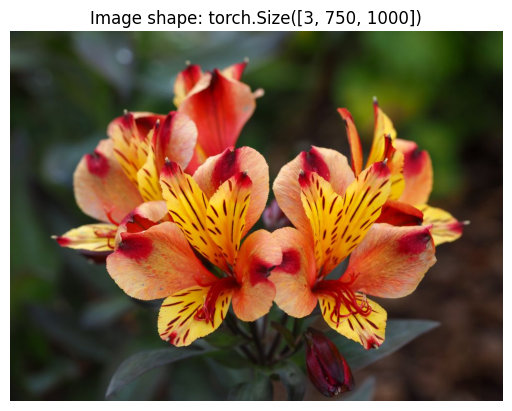

In [ ]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False)

In [ ]:
# Helper function 8

from typing import List, Tuple, Dict

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: Dict,
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):


    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ###

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))
      # print(target_image_pred)

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    # print(target_image_pred_probs)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    # print(target_image_pred_label)

    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {lily_names[str(target_image_pred_label.item())]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False)

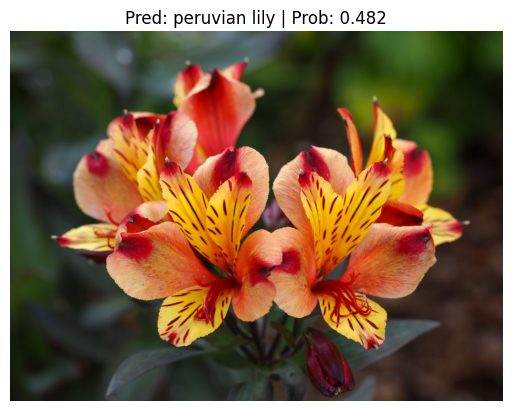

In [ ]:
pred_and_plot_image(model=densenet161,
                    image_path=custom_image_path,
                    class_names=lily_names)

## 8. Creating a Gradio demo

In [ ]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.5/447.5 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 94.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 9.2 MB/s eta 0:00:00
Gradio version: 5.4.0


### 8.1 Creating a function that takes an image as input, preprocesses it, makes a prediction with DenseNet161 and then returns the prediction (pred label) as well as the prediction probability (pred prob).

In [ ]:
# Put DenseNet161 on CPU
densenet161.to("cpu")

# Check the device
next(iter(densenet161.parameters())).device

device(type='cpu')

In [ ]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
  """Transforms and performs a prediction on img and returns prediction and time taken."""

  # Start the timer
  start_time = timer()

  # Transform the target image and add a batch dimension
  img = densenet161_transforms(img).unsqueeze(0)

  # Put model into evaluation mode and turn on inference mode
  densenet161.eval()
  with torch.inference_mode():
    # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
    pred_probs = torch.softmax(densenet161(img), dim=1)

  # Create a prediction label and prediction probability dictionary for each prediction class (the required format for Gradio's output parameter)
  pred_labels_and_probs = {target_names[i]: float(pred_probs[0][i]) for i in range(len(target_names))}

  # Calculate the prediction time
  pred_time = round(timer() - start_time, 5)

  # Return the prediction dictionary and prediction time
  return pred_labels_and_probs, pred_time

In [ ]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(pathlib.Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: ../data/flowers-102/flowers-5/test/sword lily/image_02408.jpg

Prediction label and probability dictionary: 
{'fire lily': 0.044837821274995804, 'peruvian lily': 0.09156651049852371, 'sword lily': 0.7887025475502014, 'tiger lily': 0.04310346022248268, 'water lily': 0.03178960084915161}
Prediction time: 0.42512 seconds


### 8.2 Creating a list of example images

In [ ]:
# Create a list of example inputs to the Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=5)]
example_list

[['../data/flowers-102/flowers-5/test/water lily/image_00444.jpg'],
 ['../data/flowers-102/flowers-5/test/sword lily/image_02404.jpg'],
 ['../data/flowers-102/flowers-5/test/fire lily/image_06781.jpg'],
 ['../data/flowers-102/flowers-5/test/fire lily/image_06800.jpg'],
 ['../data/flowers-102/flowers-5/test/sword lily/image_02386.jpg']]

### 8.3 Building a Gradio interface

In [ ]:
import gradio as gr

# Create title, description and article strings
title = "FlowersVision Mini"
description = "A DenseNet161 feature extractor computer vision model to classify images of flowers as fire lily, peruvian lily, sword lily, tiger lily or water lily."

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=5, label="Predictions"),
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list,
                    title=title,
                    description=description)

# Launch the demo!
demo.launch(debug=False, # print errors locally
            share=True) # generate a publically shareable URL

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8bd2cc3359be8a648e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## 9. Turning FlowersVision Mini Gradio Demo into a deployable app

In [ ]:
import shutil

# Create FlowersVision mini demo path
flowersvision_mini_demo_path = pathlib.Path("demos/flowersvision_mini/")

# Remove files that might already exist there and create new directory
if flowersvision_mini_demo_path.exists():
    shutil.rmtree(flowersvision_mini_demo_path)

# If the file doesn't exist, create it anyway
flowersvision_mini_demo_path.mkdir(parents=True,
                                exist_ok=True)

# Check what's in the folder
!ls demos/flowersvision_mini

### 9.2 Creating a folder of example images to use with the FlowersVision Mini demo

In [ ]:
# 1. Create an examples directory
flowersvision_mini_examples_path = flowersvision_mini_demo_path / "examples"
flowersvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect five random test dataset image paths
flowersvision_mini_examples = [pathlib.Path(data_dir / 'flowers-102/flowers-5/test/fire lily/image_06788.jpg'),
                               pathlib.Path(data_dir / 'flowers-102/flowers-5/test/peruvian lily/image_04299.jpg'),
                               pathlib.Path(data_dir / 'flowers-102/flowers-5/test/sword lily/image_02400.jpg'),
                               pathlib.Path(data_dir / 'flowers-102/flowers-5/test/tiger lily/image_07178.jpg'),
                               pathlib.Path(data_dir / 'flowers-102/flowers-5/test/water lily/image_00411.jpg'),
                              ]

# 3. Copy the five random images to the examples directory
for example in flowersvision_mini_examples:
    destination = flowersvision_mini_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying ../data/flowers-102/flowers-5/test/fire lily/image_06788.jpg to demos/flowersvision_mini/examples/image_06788.jpg
[INFO] Copying ../data/flowers-102/flowers-5/test/peruvian lily/image_04299.jpg to demos/flowersvision_mini/examples/image_04299.jpg
[INFO] Copying ../data/flowers-102/flowers-5/test/sword lily/image_02400.jpg to demos/flowersvision_mini/examples/image_02400.jpg
[INFO] Copying ../data/flowers-102/flowers-5/test/tiger lily/image_07178.jpg to demos/flowersvision_mini/examples/image_07178.jpg
[INFO] Copying ../data/flowers-102/flowers-5/test/water lily/image_00411.jpg to demos/flowersvision_mini/examples/image_00411.jpg


In [ ]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(flowersvision_mini_examples_path)]
example_list

[['examples/image_00411.jpg'],
 ['examples/image_02400.jpg'],
 ['examples/image_04299.jpg'],
 ['examples/image_06788.jpg'],
 ['examples/image_07178.jpg']]

### 9.3 Moving our trained DenseNet161 model to our FlowersVision Mini demo directory

In [ ]:
import shutil

# Create a source path for our target model
densenet161_flowersvision_mini_model_path = "models/01_pretrained_densenet161_feature_extractor_flowers5.pth"

# Create a destination path for our target model
densenet161_flowersvision_mini_model_destination = flowersvision_mini_demo_path / densenet161_flowersvision_mini_model_path.split("/")[1]

# Try to move the file
try:
  print(f"[INFO] Attempting to move {densenet161_flowersvision_mini_model_path} to {densenet161_flowersvision_mini_model_destination}")

  # Move the model
  shutil.move(src=densenet161_flowersvision_mini_model_path,
              dst=densenet161_flowersvision_mini_model_destination)

  print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
  print(f"[INFO] No model found at {densenet161_flowersvision_mini_model_path}, perhaps its already been moved?")
  print(f"[INFO] Model exists at {densenet161_flowersvision_mini_model_destination}: {densenet161_flowersvision_mini_model_destination.exists()}")

[INFO] Attempting to move models/01_pretrained_densenet161_feature_extractor_flowers5.pth to demos/flowersvision_mini/01_pretrained_densenet161_feature_extractor_flowers5.pth
[INFO] Model move complete.


### 9.4 Turning our DenseNet161 model into a Python script (`model.py`)

In [ ]:
%%writefile demos/flowersvision_mini/model.py
import torch
import torchvision

from torch import nn


def create_densenet161_model(num_classes:int=5,
                             seed:int=42):
  """Creates a DenseNet161 feature extractor model and transforms.

  Args:
      num_classes (int, optional): number of classes in the classifier.
      Defaults to 5.
      seed (int, optional): random seed value. Defaults to 42.

  Returns:
      model (torch.nn.Module): DenseNet161 feature extractor model.
      transforms (torchvision.transforms): DenseNet161 image transforms.
  """
  # Create DenseNet161 pretrained weights, transforms and model
  weights = torchvision.models.DenseNet161_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.densenet161(weights=weights)

  # Freeze all layers in base model
  for param in model.parameters():
    param.requires_grad = False

  # Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)
  model.classifier = nn.Linear(in_features=2208, out_features=num_classes)

  return model, transforms

Writing demos/flowersvision_mini/model.py


### 9.5 Turning our FlowersVision Mini Gradio app into a Python script (`app.py`)

In [ ]:
%%writefile demos/flowersvision_mini/app.py

### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_densenet161_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ["fire lily",
               "peruvian lily",
               "sword lily",
               "tiger lily",
               "water lily"]

### 2. Model and transforms preparation ###

# Create EffNetB2 model
densenet161, densenet161_transforms = create_densenet161_model(
    num_classes=5)

# Load saved weights
densenet161.load_state_dict(
    torch.load(
        f="01_pretrained_densenet161_feature_extractor_flowers5.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
  """Transforms and performs a prediction on img and returns prediction and time taken.
  """

  # Start the timer
  start_time = timer()

  # Transform the target image and add a batch dimension
  img = densenet161_transforms(img).unsqueeze(0)

  # Put model into evaluation mode and turn on inference mode
  densenet161.eval()
  with torch.inference_mode():
    # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
    pred_probs = torch.softmax(densenet161(img), dim=1)

  # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate the prediction time
  pred_time = round(timer() - start_time, 5)

  # Return the prediction dictionary and prediction time
  return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FlowersVision Mini"
description = "A DenseNet161 feature extractor computer vision model to classify images of flowers as fire lily, peruvian lily, sword lily, tiger lily or water lily."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=5, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    # Create examples list from "examples/" directory
                    examples=example_list,
                    title=title,
                    description=description)

# Launch the demo!
demo.launch()

Writing demos/flowersvision_mini/app.py


### 9.6 Creating a requirements file for FoodVision Mini (`requirements.txt`)

In [ ]:
%%writefile demos/flowersvision_mini/requirements.txt

torch
torchvision
gradio

Writing demos/flowersvision_mini/requirements.txt


## 10. Deploying our FlowersVision Mini app to HuggingFace Spaces

In [ ]:
!ls demos/flowersvision_mini

01_pretrained_densenet161_feature_extractor_flowers5.pth  examples  requirements.txt
app.py							  model.py


In [ ]:
# Change into and then zip the foodvision_mini folder but exclude certain files
!cd demos/flowersvision_mini && zip -r ../flowersvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Mini app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/flowersvision_mini.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download(), please manually download.")

updating: app.py (deflated 59%)
updating: examples/ (stored 0%)
updating: examples/image_00411.jpg (deflated 1%)
updating: examples/image_02400.jpg (deflated 1%)
updating: examples/image_04299.jpg (deflated 1%)
updating: examples/image_06788.jpg (deflated 1%)
updating: examples/image_07178.jpg (deflated 1%)
updating: model.py (deflated 55%)
updating: requirements.txt (deflated 8%)
  adding: 01_pretrained_densenet161_feature_extractor_flowers5.pth (deflated 5%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>